# Setting up the Kaggle API and downloading the dataset

In [4]:
# download the dataset
!kaggle competitions download -c dogs-vs-cats-redux-kernels-edition

 95% 257M/271M [00:02<00:00, 110MB/s]
100% 271M/271M [00:02<00:00, 101MB/s]
  0% 0.00/111k [00:00<?, ?B/s]
100% 111k/111k [00:00<00:00, 95.3MB/s]
 97% 528M/544M [00:11<00:00, 28.3MB/s]
100% 544M/544M [00:11<00:00, 47.6MB/s]


In [5]:
!unzip -qo test.zip
!unzip -qo train.zip

# Import the libraries

In [6]:
# deep learning
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
# utility + algebraic computations
import numpy as np

import PIL
import os
from skimage import io
from glob import glob
# visualisation
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

# misc
import time

# Prepare the data
In order to have more tidily working space, I'll disjoin the classes into different folders

We can see that the classes are seperated by "cat" or "dog" keyword at the beginning of the image file. So moving them to different folders by that keyword would do the job.

In [7]:
glob('train/*')[:5]

['train/cat.6653.jpg',
 'train/dog.410.jpg',
 'train/dog.7147.jpg',
 'train/dog.10576.jpg',
 'train/cat.10949.jpg']

In [8]:
# move the data to different folders
# create folders for different classes
!mkdir train/Dog
!mkdir train/Cat
# move the data
!mv train/dog.* train/Dog/
!mv train/cat.* train/Cat/

In [9]:
print(glob('train/*'))
print(glob('train/Cat/*')[:5])
print(glob('train/Dog/*')[:5])

['train/Dog', 'train/Cat']
['train/Cat/cat.6653.jpg', 'train/Cat/cat.10949.jpg', 'train/Cat/cat.6754.jpg', 'train/Cat/cat.4735.jpg', 'train/Cat/cat.11542.jpg']
['train/Dog/dog.410.jpg', 'train/Dog/dog.7147.jpg', 'train/Dog/dog.10576.jpg', 'train/Dog/dog.10722.jpg', 'train/Dog/dog.9256.jpg']


# Create custom dataset

We already disjoint the data to labeled folders. I just need to create simple dataset class for reading, checking and getting the images. It also should be able to apply transformations to given data.

In [10]:
class DogsCatsDataset(torch.utils.data.Dataset):
  """ Dogs vs Cats Dataset """

  def __init__(self, path, transform = None):
    """
    Args:
      path (str): Path to directory with all images. (This path also can have image directories as subfolders)
      transform (callable, optional): Optional transform to be applied on a sample. 
    """
    self.path = path
    self.transform = transform
    self._classes = {}
    self._im_paths = []

    self._get_paths()

  def _get_paths(self):
    for root, dirs, files in os.walk(self.path):
      # get the images inside of the subdirectory (if there are any subdirectories). 
      # (in this case there shouldn't be any images outside of these subfolders and the subfolders should point out the different classes)
      if len(dirs) != 0:
        for i in range(len(dirs)):
          self._classes[i] = dirs[i] # one-hot-encode the given directory (which is also a class label) | ex. {0 : 'Cat', 1 : 'Dog'}
          dir_path = os.path.join(self.path, dirs[i])
          for im_name in os.listdir(dir_path):
            im_path = os.path.join(dir_path, im_name)
            self._im_paths.append([im_path, i])
      else: 
        # if there aren't any subfolder that indicates different classes then root path is the path for images. 
        # by reason of not having any subdirectories that states any class, I just pass the image paths to _im_paths attribute.
        # these image files are already specified in "files" so I'll be using this to iterate through entire folder. 
        for im_name in files:
          im_path = os.path.join(self.path, im_name)
          self._im_paths.append(im_path)
      break # I just need the first iteration of os.walk

  def __len__(self):
    return len(self._im_paths)
  
  def __getitem__(self, idx):
    # convert the index to list if its a tensor
    if torch.is_tensor(idx):
      idx.tolist()
    
    # now get the image path and the label (if there's a label)
    if len(self._classes) != 0:
      img_path, label = self._im_paths[idx]
    else:
      img_path = self._im_paths[idx]
    
    # apply the transforms (optional)
    if self.transform:
      # read the image as PIL.Image
      img = PIL.Image.open(img_path)
      img = self.transform(img)
    else:
      img = plt.imread(img_path)

    if len(self._classes) != 0:
      sample = {'image': img, 'label': label}
    else:
      sample = {'image': img}

    return sample

In [11]:
train_ds = DogsCatsDataset('train/')
test_ds = DogsCatsDataset('test/')

In [12]:
print('Length of training set:', len(train_ds))
print('Length of test set:', len(test_ds))

Length of training set: 25000
Length of test set: 12500


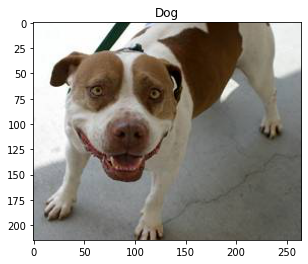

In [13]:
# Plot a random image from train dataset
r = np.random.randint(0, len(train_ds))
img, label = train_ds[r]['image'], train_ds[r]['label']
plt.imshow(img)
plt.title(train_ds._classes[label])
plt.show()

In [14]:
transformations = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(.1),
        transforms.Resize(size = (180,180)),
        transforms.ToTensor(),
])

In [15]:
transformed_tr_ds = DogsCatsDataset('train/', transformations)

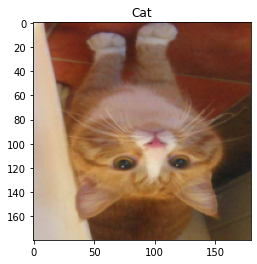

In [16]:
# Plot a random image from transformed training set
r = np.random.randint(0, len(transformed_tr_ds))
img, label = transformed_tr_ds[r]['image'], transformed_tr_ds[r]['label']
plt.imshow(img.numpy().transpose((1,2,0)))
plt.title(transformed_tr_ds._classes[label])
plt.show()

In [17]:
# initalize train and test data loaders
batch_size = 128
train_loader = torch.utils.data.DataLoader(transformed_tr_ds, batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size = batch_size, shuffle = False)

# Prepare the model
I'll use smaller version of Xception. It's my first time of implementing a CNN architecture my own so it'll probably differ from the original structure. 
But since I want to use xception module, I need to implement "same" mode convolutions so input and output will be in equal shapes. In order to do that, I'll use the formula given at pytorch documentations. 

(src:https://pytorch.org/docs/master/generated/torch.nn.Conv2d.html)

In [18]:
#@title Old inception implementation
class Inceptionv1(nn.Module):
  def __init__(self, K):
    super(Inceptionv1, self).__init__()
    
    self.tail = nn.Sequential(
      nn.Conv2d(3, 32, kernel_size = 3, stride = 2),
      nn.ReLU(),

      nn.MaxPool2d(3, stride = 2),

      nn.Conv2d(32, 64, kernel_size = 1, padding = 1),
      nn.BatchNorm2d(64),
      nn.ReLU(),

      nn.Conv2d(32, 64, kernel_size = 3, padding = 1),
      nn.BatchNorm2d(64),
      nn.ReLU()
    )


    self.sep_conv_1 = nn.Sequential(
        nn.Conv2d(64, 128, 1),
        nn.BatchNorm2d(128),
        nn.ReLU()
        )
    
    self.sep_conv_2 = nn.Sequential(
        nn.Conv2d(64, 128, 1),
        nn.BatchNorm2d(128),
        nn.ReLU()
        )
    
    self.sep_conv_11 = nn.Sequential(
        nn.Conv2d(128, 256, 3),
        nn.BatchNorm2d(256),
        nn.ReLU()
    )

    self.sep_conv_22 = nn.Sequential(
        nn.Conv2d(128, 256, 5, padding = 1),
        nn.BatchNorm2d(256),
        nn.ReLU()
    )

    self.drop_out = nn.Dropout()
    self.max_pool = nn.MaxPool2d(3, stride = 2)
    self.fc = nn.Linear(256, K)

  def forward(self,x):
    x = self.tail(x)

    x = self.max_pool(x)

    x1 = self.sep_conv_1(x)
    x1 = self.sep_conv_11(x1)
    x2 = self.sep_conv_2(x)
    x2 = self.sep_conv_22(x2)

    x = x1 + x2 # add up the layers

    x = x.mean([2,3]) # global average pooling
    x = self.drop_out(x)
    x = x.view(x.size(0), -1) # flatten the data
    x = self.fc(x)
    x = torch.sigmoid(x)

    return x

In [48]:
class Xception_v1(nn.Module):
  def __init__(self, K, device):
    super(Xception_v1, self).__init__()

    self._device = device

    self.conv1 = nn.Conv2d(3, 32, kernel_size = 2, stride = 2)
    self.bn1 = nn.BatchNorm2d(32)
    self.act1 = nn.ReLU()

    self.conv2 = nn.Conv2d(32, 64, kernel_size = 3, padding = 1)
    self.bn2 = nn.BatchNorm2d(64)
    self.act2 = nn.ReLU()

    self.conv3 = nn.Conv2d(728, 1024, kernel_size = 3, padding = 1)
    self.bn3 = nn.BatchNorm2d(1024)
    self.act3 = nn.ReLU()

    self.global_avg_pool = lambda x: x.mean([2,3]) 

    if K==2:
      self.fc_act = nn.Sigmoid()
      nout = 1
    elif K>2:
      self.fc_act = nn.Softmax()
      nout = K
    
    self.dropout = nn.Dropout(0.5)
    self.fc = nn.Linear(1024, nout)

  def forward(self, x):
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.act1(x)

    x = self.conv2(x)
    x = self.bn2(x)
    x = self.act2(x)


    prev = x

    sizes = [64, 128, 256, 512, 728]
    for i in range(len(sizes)-1):
      sepconv = xception_module_v2(sizes[i],sizes[i+1])
      sepconv._prev = prev

      sepconv.to(self._device)

      x = sepconv(x) # returns the residual+data if sepconv._prev is not None
      # print(f"{i+1}th Xception module output shape:", x.shape)


      prev = x
    
    x = self.conv3(x)
    x = self.bn3(x)
    x = self.act3(x)

    x = self.global_avg_pool(x)

    x = self.dropout(x)
    x = self.fc(x)
    x = self.fc_act(x)

    return x

#### sep conv2d implement etmeye çalışıyorum ama boyutlar doğru olmuyor, bunu çözmek için alternatife ihtiyacım var. Hesaplamaları tekrar gözden geçirip 
#### duruma göre same conv uygulayabilirim.
class xception_module_v2(nn.Module):
  def __init__(self, nin, nout):
    super(xception_module_v2, self).__init__()
    self._prev = None
    self.act = nn.ReLU()
    
    self.depthwise_sep_conv1 = nn.Conv2d(nin, nin, kernel_size = 3, padding = 1, groups = nin)
    self.bn1 = nn.BatchNorm2d(nin)

    self.depthwise_sep_conv2 = nn.Conv2d(nin, nout, kernel_size = 3, padding = 1, groups = nin)
    self.bn2 = nn.BatchNorm2d(nout)

    self.pointwise_sep_conv = nn.Conv2d(nin, nout, kernel_size = 1, stride = 2)
    self.mpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)

  def forward(self, x):
    print("Input shape:", x.shape)
    x = self.depthwise_sep_conv1(x)
    x = self.bn1(x)
    x = self.act(x)

    x = self.depthwise_sep_conv2(x)
    x = self.bn2(x)
    x = self.act(x)

    x = self.mpool(x)

    print("Input shape before max pooling:", x.shape)
    x = self.mpool(x)
    print('Input shape after max pooling:', x.shape)

    if self._prev != None:
      r = self.pointwise_sep_conv(self._prev)
      print("Output after pointwise separate convolution:", r.shape)
      x = x + r
    return x

class xception_module_v1(nn.Module):
  def __init__(self, nin, nout):
    super(xception_module_v1, self).__init__()
    self._prev = None

    self.act = nn.ReLU()

    self.conv1 = nn.Conv2d(nin, nin, kernel_size = 3, padding = 1 )
    self.bn1 = nn.BatchNorm2d(nin)
    self.act1 = nn.ReLU()

    self.conv2 = nn.Conv2d(nin, nout, kernel_size = 3, padding = 1 )
    self.bn2 = nn.BatchNorm2d(nout)
    self.act2 = nn.ReLU()


    self.mpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
  
    self.residual = nn.Conv2d(nin, nout, kernel_size = 1, stride = 2)

  def forward(self,x):
    x = self.act(x)

    x = self.conv1(x)
    x = self.bn1(x)
    x = self.act1(x)

    x = self.conv2(x)
    x = self.bn2(x)
    x = self.act2(x)

    x = self.mpool(x)
    if self._prev != None:
      r = self.residual(self._prev)
      x = x + r

    return x
  



## Initialize Loss function and Optimizer (also pass the model to GPU if available)

In [49]:
from torchsummary import summary

# check if cuda device is available, pass the model to cpu if it isn't
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
print(device)

model = Xception_v1(2, device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters())


model.to(device);

summary(model, (3,180,180))

cuda:0
Input shape: torch.Size([2, 64, 90, 90])
Input shape before max pooling: torch.Size([2, 64, 45, 45])
Input shape after max pooling: torch.Size([2, 64, 23, 23])
Output after pointwise separate convolution: torch.Size([2, 128, 45, 45])


RuntimeError: ignored

# Define train and prediction functions

In [22]:
def train(model, criterion, optimizer, train_loader, epochs = 10):
  """
  Apply batch gradient descent to model with DataLoader object.

  Args:
    model (torch.nn.Module instance): PyTorch model to apply gradient descent
    criterion (function): A function for calculating the loss, it may be custom or not. (I don't know if using custom loss function works but it should work) 
    optimizer (function): An optimizer function for optimization of parameters based on the computed gradients. It can be custom or not. (same as "criterion" arg.)
    train_loader (torch.nn.data.DataLoader instance): DataLoader object for training dataset. 
    epochs (int): Number of epochs for training. (Optional, it's 10 as default)
  """

  train_losses = np.zeros(epochs)
  train_accuracies = np.zeros(epochs)

  for i in range(epochs):
    t0 = time.time()
    losses = []

    for data in train_loader:
      input_batch, target_batch = data['image'], data['label']
      input_batch, target_batch = input_batch.to(device), target_batch.to(device)
      # reshape the target data so it'll be in the shape of NxC where C is number of classes we have.
      # I know we have 2 classes but finding 1 would be enough since we can calculate the other one by simply looking at sigmoid outputs.
      target_batch = target_batch.view(-1, 1)
      # forward prop
      outputs = model(input_batch)
      # I passed target batch as a float because I got an error when I tried to pass it as a int64 (long)
      # Passing data to criterion as (float32, int64) worked for my other projects but it didn't work in this case. 
      # I don't know why it doesn't work in this case, it may be related with BCELoss cost function.
      loss = criterion(outputs, target_batch.to(torch.float32))
      # backward prop
      loss.backward()
      optimizer.step()
      optimizer.zero_grad() # reset the gradients to prevent gradient accumulation
    
      # keep the loss to plot it later
      losses.append(loss.item())

    _, accuracy = predict(model, train_loader)
    avg_loss = np.mean(losses)
    train_losses[i] = avg_loss
    train_accuracies[i] = accuracy

    # save the model to checkpoint dictionary
    # create the directory if it doesn't exist
    cp_path = 'checkpoints'
    if cp_path not in os.listdir():
      os.system(f'mkdir {cp_path}')

    model_path = cp_path + f'/xception_epoch_{i+1}.pth' 
    torch.save({
        'epoch':epochs+1,
        'model_state_dict':model.state_dict(),
        'optimizer_state_dict':optimizer.state_dict(),
        'loss':avg_loss,
        'accuracy': accuracy
    },model_path)


    t1 = time.time()
    print("-"*50)
    print(f"Epoch {i+1}/{epochs} took {t1-t0:.3f}s \n avg_loss for train: {avg_loss:.4f} \n train_accuracy: {accuracy:.4f}")
    print(f"Checkpoint saved to:", model_path)
    print("-"*50)

  return train_accuracies, train_losses

def predict(model, data_loader, calc_acc=True):
  n_total = 0
  n_correct = 0
  predictions = np.array([])
  with torch.no_grad():
    for data in data_loader:
      features, targets = data['image'], data['label']
      features, targets = features.to(device), targets.to(device)
      outputs = model(features)
      preds = torch.round(outputs).view(-1)
      if calc_acc:
        n_correct += ((preds == targets.view(-1)).sum().item())
        n_total += (targets.shape[0])
      predictions = np.concatenate((predictions, preds.cpu().numpy()))

  return [predictions, (n_correct/n_total)] if calc_acc else predictions


In [23]:
n_epochs = 1  
train_accuracies, train_loss = train(model, criterion, optimizer, train_loader, n_epochs)

--------------------------------------------------
Epoch 1/1 took 577.500s 
 avg_loss for train: 0.6828 
 train_accuracy: 0.6050
Checkpoint saved to: checkpoints/xception_epoch_1.pth
--------------------------------------------------


In [ ]:
x = list(range(1,n_epochs+1))
acc_fig = px.line(x=x, y = train_accuracies, title = 'Train accuracies')
loss_fig = px.line(x=x, y = train_loss, title = 'Train losses')
acc_fig.show()
loss_fig.show()

In [ ]:
# pass the latest model to the google drive

# mount the google drive
from google.colab import drive
drive.mount('drive')

# create a directory to move the model
!mkdir drive/"My Drive"/"Cats vs Dogs PyTorch"

# get the latest model
model_path = glob('checkpoints/*')[-1]

# move the model to the directory we created before
!mv {model_path} drive/"My Drive"/"Cats vs Dogs PyTorch"